# Exploratory Data Analysis - Predicting Kilocalories in Food
## Abstract
With this dataset, I intend to find the relationship between macro/micro nutrients and Kilocalories in food. I will use SHRUTI SAXENA's [Food Nutrition Dataset](https://www.kaggle.com/datasets/shrutisaxena/food-nutrition-dataset?resource=download&select=food.csv) which is based on the USDA's [FoodData Central database](https://fdc.nal.usda.gov/fdc-app.html#/) to build a model that can predict the calories in a food based on key nutritional information.

## Packages and Libraries

In [ ]:
import mlxtend
# Addding the dataset from github https://github.com/vraosharma-northeastern/exploratory-data-analysis/blob/main/Nutrition%20/food.csv
!wget https://raw.githubusercontent.com/vraosharma-northeastern/exploratory-data-analysis/main/Nutrition%20/food.csv

In [ ]:
# Importing the necessary libraries
import numpy as np
import statsmodels.api as sm
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from scipy.stats import shapiro
from statistics import LinearRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.feature_selection import VarianceThreshold

## Dataset Overview & Cleanup
In this section we will evaluate the hygiene of the dataset and clean it up as necessary

In [ ]:
#Reading the file into a dataframe and viewing the first few rows
df = pd.read_csv('food.csv')

# Loop through columns and remove redundant 'Data.' tag from column names
for col in df.columns:
    new_col = col.replace('Data.', '')  # Remove 'Data.' from the column name
    df.rename(columns={col: new_col}, inplace=True)  # Rename the column name in dataframe

# Show the first few rows of the dataset
df.head()

As we can see above, each row represents a food type; the *Description* column contains a breakdown of the few ingredients that comprise the dish or food as well as details of how it was prepared. Some foods have multiple entries in the dataset because they were prepared in different ways, e.g. raw, cooked, fried, etc. Additionally, some foods have multiple entries because they were prepared with different ingredients, e.g. with or without salt, with or without sugar, etc.

The consistency of the data also presents a challenge. For example, the *Category* column contains a few entries that are not necessarily food types, e.g. 'Spices and Herbs', 'no category', etc. and occassionally foods of the same type are split into categories by brand e.g. 'Soup', 'Campbell's Soup'. I am not sure if this is intentional or not, but I will leave this data as is for now. To clean this up, I could use GPT to classify the foods into categories, but that is outside the scope of this project.

**What are the data types?**: Below, we can see the data types in this dataset are object (string), float64, and int64.

In [ ]:
# Show data types and count of attributes per that type
df.dtypes.value_counts()

**Are there missing values?**: As we can see below, there are only null values in the two 'Household Weight Description' columns.

In [ ]:
# Find percentage of null values and sort by missing %
df.isnull().sum().sort_values(ascending=False) / len(df) * 100

Because *2nd Household Weight* and *1st Household Weight* are the same measure expressed in different units and this column has more nulls, we will drop *2nd Household Weight* and it's corresponding *Household Weights.2nd Household Weight Description* below.

Also, because Household Weight Description doesn't really tell us anything that the *Household Weights.1st Household Weight* already containes, we will drop *Household Weights.1st Household Weight Description* as well.

In [ ]:
# Drop 'Household Weight Description' columns
df.drop(['Household Weights.2nd Household Weight Description', 'Household Weights.2nd Household Weight','Household Weights.1st Household Weight Description'], axis=1, inplace=True)

Despite having only non-null values, both categorical and numeric attributes of this dataset have a few "placeholder" values. Let's quantify these.


In [ ]:
# Find the number of values in the 'Category' column that ci match '%no category%'
df[df['Category'].str.contains('no category', case=False)]['Category'].count()/ len(df)

We can see that the *Category* column has less than 3% of its values labeled 'no category'. This is not a significant amount of data. Because we're trying to predict Kilocalories, and we don't care too much about the taxonomy of food types, we will keep these records.

Let's now target the numeric columns. We will look for values that are 0, which are likely placeholders for missing data.

In [ ]:
# Show the percentage of 0s in each numeric column of the dataset. In another table, show the percentage of 1s in each numeric column of the dataset.

df.select_dtypes(include=['float64', 'int64']).apply(lambda x: x[x == 0].count() / len(df)).sort_values(ascending=False)

Because we're dealing with a variety of foods, it makes sense that certain nutrients would be absent, so we will not impute any of these values. However, all foods should have a Weight (g) greater than 0. We will remove all rows where the Weight (g) is 0.

In [ ]:
# Drop rows where Household Weights.1st Household Weight is 0
df = df[df['Household Weights.1st Household Weight'] != 0]

Next, let's limit the scope of our dataset to exclude information that gives is found in small quantities in food. We will remove the following columns to simplify our analysis because we don't care about their correlation to KCAL:
1. **Alpha Carotene**
2. **Beta Carotene**
3. **Beta Cryptoxanthin**
4. **Lycopene**
5. **Lutein and Zeaxanthin**
6. **Retinol**
7. **Riboflavin**
8. **Selinium**
9. **Thiamin**
10. **Choline**
11. **Manganese**
12. **Niacin**
13. **Pantothenic Acid**
14. **Refuse Percentage**

In [ ]:
# Drop columns that are not relevant to our analysis
df.drop(['Alpha Carotene', 'Beta Carotene', 'Beta Cryptoxanthin', 'Lycopene', 'Lutein and Zeaxanthin', 'Retinol', 'Riboflavin', 'Selenium', 'Thiamin', 'Choline', 'Manganese', 'Niacin', 'Pantothenic Acid', 'Refuse Percentage'], axis=1, inplace=True)

We will also drop *Vitamin A - IU* because it is redundant to *Vitamin A - RAE* and the [NIH](https://ods.od.nih.gov/factsheets/VitaminA-HealthProfessional/#:~:text=The%20units%20of%20measurement%20for,beta%2Dcarotene%20%3D%200.3%20mcg%20RAE) recommends using *Vitamin A - RAE* to measure Vitamin A intake.

In [ ]:
# Drop *Vitamin A - IU* because it is redundant with *Vitamin A - RAE*
df.drop(['Vitamins.Vitamin A - IU'], axis=1, inplace=True)

Documentation for the dataset is a bit weak. For example, though the first few attributes have clearly defined units in Kaggle, the units for the remaining numeric attributes are not mentioned. Using the source of the data, the USDA FoodData Central, we can compare the values in our dataset to the source of truth and assume the units for each column. To make this simple, we will take the dataset's first entry, Butter [1001](https://fdc.nal.usda.gov/fdc-app.html#/food-details/790508/nutrients). We will assume that the units for each column are the same as the units in the source of truth unless values are off by order(s) of magnitude:

**Attribute: Unit**
1. Ash: g
2. Carbohydrate: g
3. Cholesterol: mg
4. Fat.Monosaturated Fat: g
5. Fat.Polysaturated Fat: g
6. Fat.Saturated Fat: g
7. Fat.Total Lipid: g
8. Fiber: g
9. Household Weights.1st Household Weight: g
10. Kilocalories: kcal
11. Major Minerals.Calcium: mg
12. Major Minerals.Copper: mg
13. Major Minerals.Iron: mg
14. Major Minerals.Magnesium: mg
15. Major Minerals.Phosphorus: mg
16. Major Minerals.Potassium: mg
17. Major Minerals.Sodium: mg
18. Major Minerals.Zinc: mg
19. Protein: g
20. Sugar Total: g
21. Vitamins.Vitamin A - RAE: µg
22. Vitamins.Vitamin B12: µg
23. Vitamins.Vitamin B6: µg
24. Vitamins.Vitamin C: µg
25. Vitamins.Vitamin E: mg
26. Vitamins.Vitamin K: µg
27. Water: g

In [ ]:
# Show the first row of the dataset in alphabetical order
df.sort_index(axis=1).head(1)

 **Which independent variables have missing data? How much?**: Now that we've cleaned the dataset of irrelevant data, let's look at the missing values again. We can see below that there are no missing values. Remember, we have those  'no category' records in the *Category* column (3%).

In [ ]:
# Find percentage of null values and sort by missing %
df.isnull().sum().sort_values(ascending=False) / len(df) * 100

**What are the likely distributions of the numeric variables?**: Now that we've cleaned up the dataset, let's see the distributions of the numeric variables. We will use a histogram to visualize the distributions of the numeric variables.

## Data Profiling

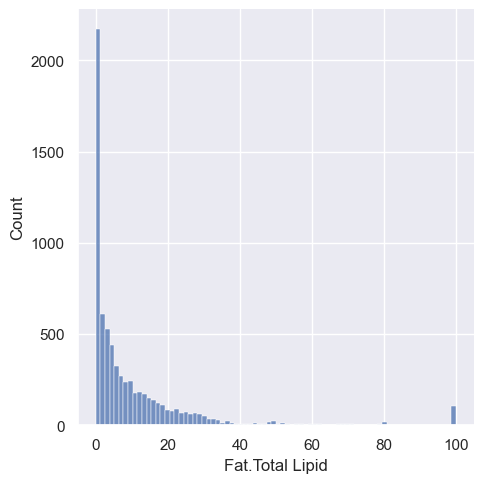

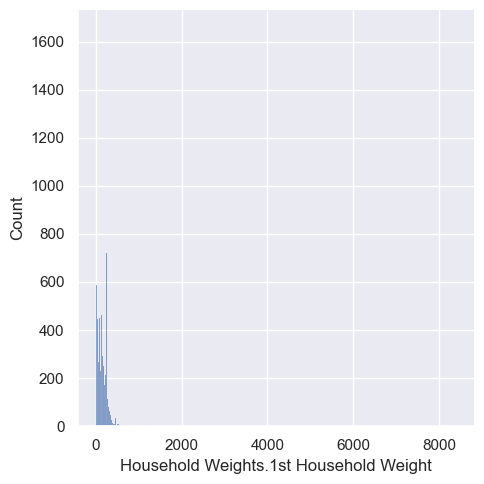

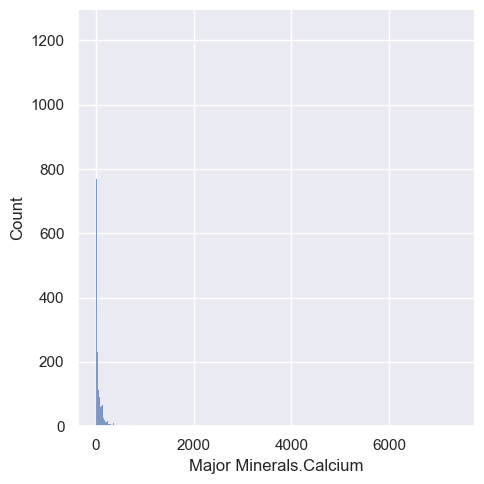

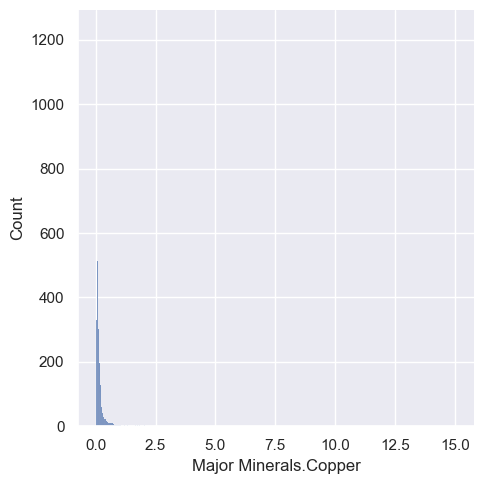

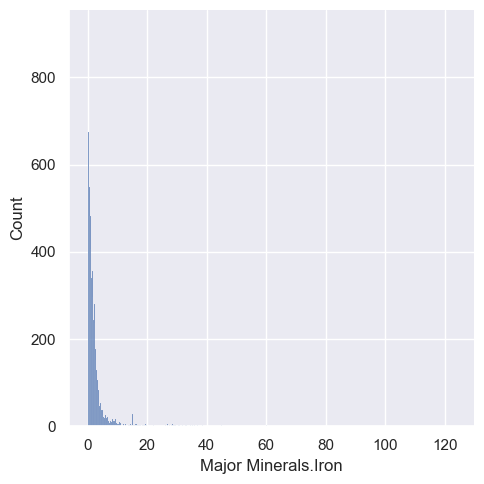

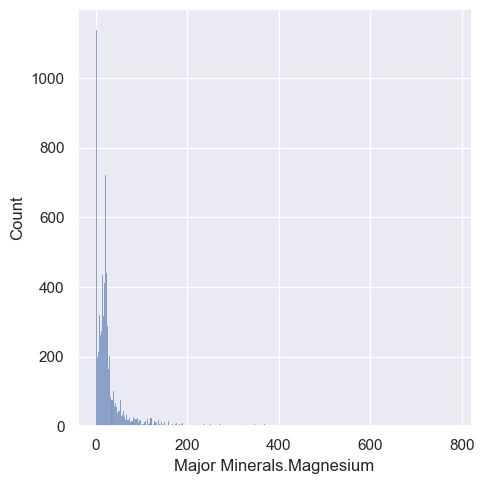

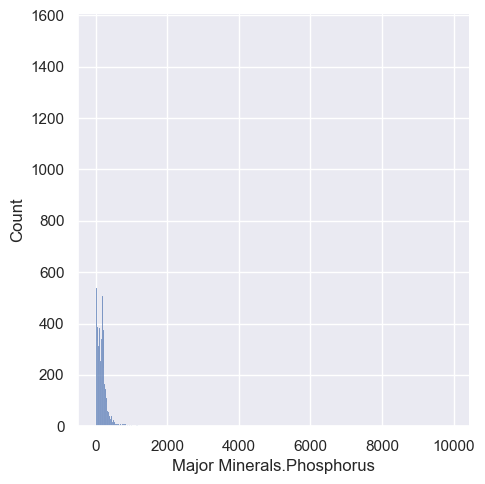

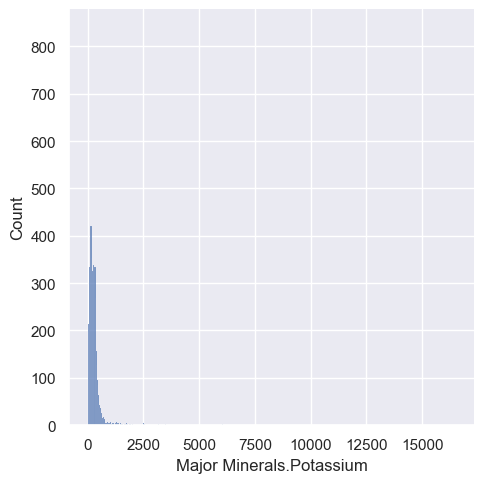

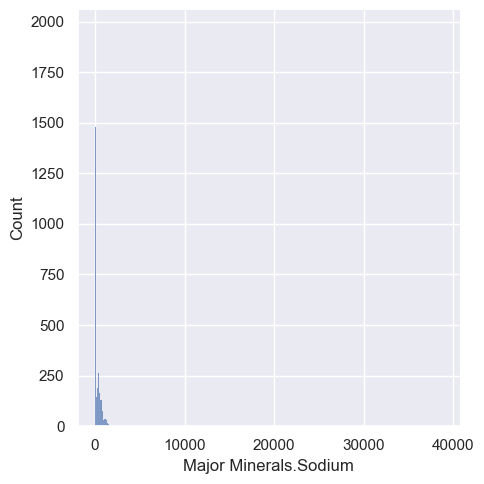

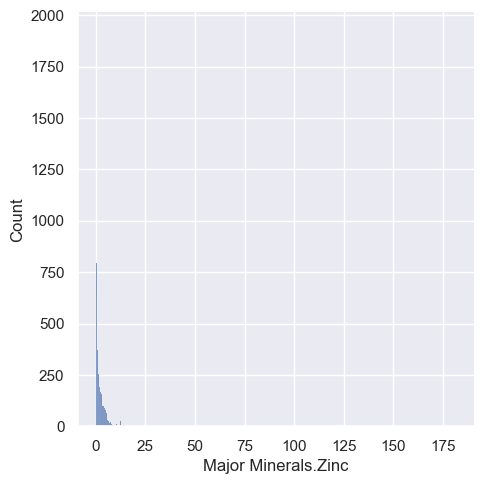

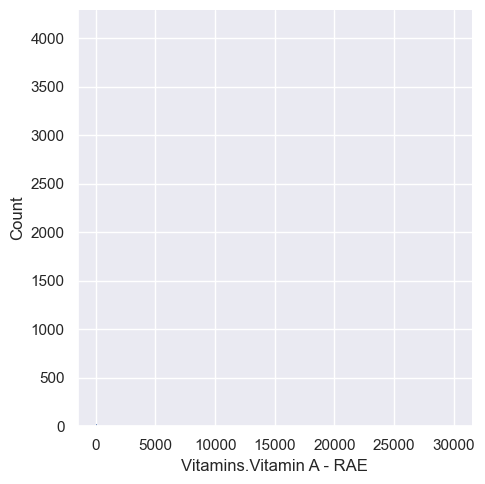

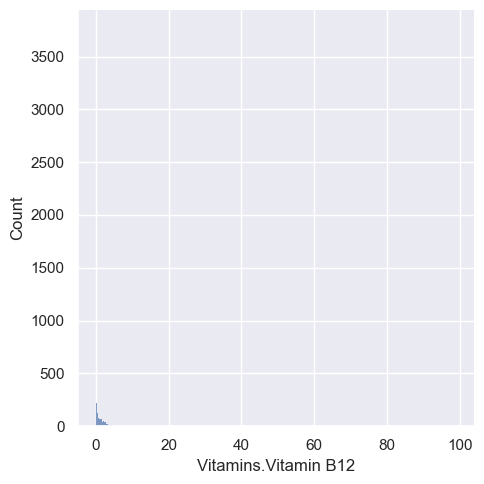

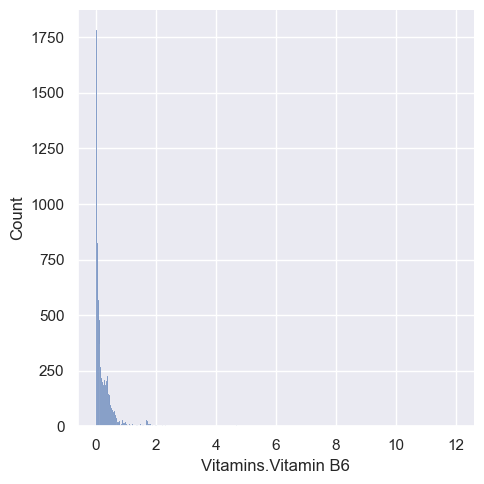

In [ ]:
# Add the numeric columns excluding Nutrient Data Bank Number to a list
numeric_cols = df.select_dtypes(include=['float64', 'int64']).drop(['Nutrient Data Bank Number'], axis=1)

#create a histogram for each numeric column
for column in numeric_cols.columns:
    sns.set(rc={"figure.figsize": (8, 4)})
    sns.displot(df[column])
    plt.show()



We can see that the distributions of the numeric variables are very right-tailed. This is expected - for example, some foods are very rich in Vitamin A like Cod Liver, while others have none.

The only variable that looks roughly normal is *Water*. Let's perform the Shapiro-Wilk test to verify if Water's or any other of the distributions are normal.

In [ ]:
# Perform the Shapiro-Wilk test on each numeric column excluding Nutrient Data Bank Number
for column in numeric_cols.columns:
    stat, p = shapiro(df[column])
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        print('{} looks Normal (fail to reject H0)'.format(column))
    else:
        print('{} does not look Normal (reject H0)'.format(column))

As we can see above, none of the distributions are normal. This is expected because the distributions are right-tailed. We will not transform the data to make it normal because we are not using any models that require normality.

***Note to Reader*** - I am not sure if the Shapiro-Wilk test is the perfect test to use here. Also, I attempted to show QQ plots for this data to understand if the distributions were another common distribution, but I was not able to tell.

## Feature Selection
Now that we have an idea of what we're working with, let's see which columns are the most useful for predicting Kilocalories. We will use three methods to determine which features are the most useful:
1. **Pearson's Correlation**: We will use Pearson's Correlation to determine which features are the most correlated to Kilocalories. We will use a threshold of 0.5.
2. **Sequential Feature Selection**: We will use Sequential Feature Selection to determine which features are the most useful. We will use a linear regression model to determine the best features. We will use a step size of 1 and a cross-validation of 5.
3. **Variance Thresholding**: We will use Variance Thresholding to determine which features are the most useful. We will use a threshold of 0.2.

**Which independent variables are useful to predict a target (dependent variable)? (Use at least three methods)**

First up, let's use ***Pearson's Correlation*** look at the relationships between *Kilocalories* and the other numeric variables.

In [ ]:
# Create a copy of the dataset
df_fs_correlation = df.copy()

# Only keep feature candidates
df_fs_correlation = df_fs_correlation.select_dtypes(include=['float64', 'int64']).drop(['Nutrient Data Bank Number'], axis=1)

# Create a correlation matrix of all independent variables
corr_matrix = df_fs_correlation.corr()

# Create a heatmap of all independent variables
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()


A few things jump out at us from the heatmap that will help us narrow down our features:
1.  *Fat.Total Lipid* and the other sub-types of fat (e.g. *Monounsaturated*, *Saturated*) are highly correlated to each other. This makes sense because Total Lipid is the sum of the other sub-types of fat. Because we are trying to predict *Kilocalories*, we will keep *Fat.Total Lipid* and drop the other sub-types of fat. The high correlation shows us that Total Fat will likely be our best predictor of Calories and this will help mitigate the multi-collinearity between the sub-types of fat.
2. Water's negative correlation to *Kilocalories* will likely make it a great feature to keep. Because foods like vegetables are mostly water and have few calories this makes sense.
3. Major Minerals seem to be clustered together as well, for example *Calcium* and *Phosphorus* are highly correlated. None of these minerals are highly correlated to *Kilocalories*, so we will drop them.
4. Interestingly *Sodium* and *Ash* are highly correlated. The relationship between these two is not clear. Because we dropped Sodium in the previous step, we will keep Ash.
5. Vitamins in this dataset appear to be clustered together as well. None of these vitamins are highly correlated to *Kilocalories*, with an exception of *Vitamin E*. In order to satisfy the requirements of the assignment to use a categorical variable, we will introduce a new feature called *Vitamin E Present* that will be a binary variable indicating whether or not a food contains Vitamin E.

In [ ]:
# Create a dummy column called 'Vitamin E Present' that is 1 if Vitamin E is present and 0 if it is not
df['Vitamin E Present'] = np.where(df['Vitamins.Vitamin E'] > 0, 1, 0)

# Create a dummy column called 'Vitamin E Present' that is 1 if Vitamin E is present and 0 if it is not
df_fs_correlation['Vitamin E Present'] = np.where(df_fs_correlation['Vitamins.Vitamin E'] > 0, 1, 0)

In [ ]:
# Drop columns that Pearson's test highlighted as not useful above
df_fs_correlation.drop(['Fat.Monosaturated Fat', 'Fat.Polysaturated Fat', 'Fat.Saturated Fat', 'Major Minerals.Calcium', 'Major Minerals.Copper', 'Major Minerals.Iron', 'Major Minerals.Magnesium', 'Major Minerals.Phosphorus', 'Major Minerals.Potassium', 'Major Minerals.Sodium', 'Major Minerals.Zinc', 'Vitamins.Vitamin A - RAE', 'Vitamins.Vitamin B12', 'Vitamins.Vitamin B6', 'Vitamins.Vitamin C', 'Vitamins.Vitamin E', 'Vitamins.Vitamin K'], axis=1, inplace=True)

# Show our current Feature Set after analysis of Pearson's Correlation
df_fs_correlation.info()

Next, let's use ***Sequential Feature Selection*** to select the best features. We will use a step size of 1 and a cross-validation of 5.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# Create a copy of the dataset
df_fs_SFS = df.copy()
df_fs_SFS = df_fs_SFS.select_dtypes(include=['float64', 'int64']).drop(['Nutrient Data Bank Number'], axis=1)

X = df_fs_SFS.drop(['Kilocalories'], axis=1)
y = df_fs_SFS[['Kilocalories']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a linear regression model
model = LinearRegression()

# Initialize the SequentialFeatureSelector
sfs = SFS(model,
          k_features='best',  # Select the best number of features automatically
          forward=True,  # Perform forward feature selection
          floating=False,  # No floating feature selection
          scoring='neg_mean_squared_error',  # Scoring metric (RMSE in this case)
          cv=5  # Cross-validation folds
          )

# Fit the SFS object to the training data
sfs = sfs.fit(X_train, y_train)

# Get the selected feature indices and names
selected_feature_indices = sfs.k_feature_idx_
selected_feature_names = X.columns[list(selected_feature_indices)]

# Get the best subset of features
best_subset = X_train.iloc[:, list(selected_feature_indices)]

# Fit the model with the best subset of features
model.fit(best_subset, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test[selected_feature_names])

# Calculate RMSE on the test set
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE with selected features: {rmse}")

# Print the selected feature names
print("Selected Features:", selected_feature_names)

# Update df_fs_SFS to only include the selected features
df_fs_SFS = df_fs_SFS[selected_feature_names]

In [ ]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_dev')
plt.title('Sequential Forward Selection')
plt.grid()
plt.show()

As we can see above, the Sequential Feature Selection method resulted in similar results to the Pearson's Correlation method. That said:
1. Again, we should follow the principle above to drop the sub-types of fat and keep *Fat.Total Lipid*.
2. This method indicates that micronutrients like *Vitamin B6* and *Copper*  may have a larger impact on *Kilocalories* than the others, but we will drop them all (aside from our dummy var *Vitamin E* present) because it will affect the interpretibility of our model - it may lead us to false conclusions (e.g. high Copper foods are super low cal!). Keeping some of these micronutrients may also cause multi-collinearity issues with the other micronutrients.
3. Interestingly, this method indicated that *Protein* may not be a good predictor of *Kilocalories*. This makes sense because high protein foods, unlike high fat foods tend to be lower in calories.
4. We see *Cholesterol* show up here, which could de-stabilize our model given its correlation to *Fat.Total Lipid*. We will keep it for now because it is a significant predictor of *Kilocalories* according to both methods.

Finally, let's use ***Variance Thresholding***. This is a simple method that removes features whose variance does not meet a certain threshold. Given our right-tailed histograms, we should take this step to ensure our features are decently spread out. We will use a threshold of 0.2.

Because we have a good idea of what our features are from the methods above, we will use the intersection of the features from the Pearson's Correlation method and the Sequential Feature Selection method and exclude anything that doesn't meet our threshold.

In [ ]:
# Create a VarianceThreshold object with a threshold of 0.2
from sklearn.feature_selection import VarianceThreshold
vt = VarianceThreshold(threshold=0.2)

# Create copy of our df for feature selection
df_fs_vt = df.copy()

# Only keep feature candidates
df_fs_vt = df_fs_vt.select_dtypes(include=['float64', 'int64']).drop(['Nutrient Data Bank Number'], axis=1)

# Fit the VarianceThreshold object to ds_fs_ffs
vt.fit(df_fs_vt)

# Create a boolean mask from the VarianceThreshold object
mask = vt.get_support()

# Create a reduced dataset by applying the mask to ds_fs_ffs
reduced_ds_fs_ffs = df_fs_vt.loc[:, mask]

# Create a list of features to keep
df_selected_features = reduced_ds_fs_ffs.copy()

# Show the list of features to keep
df_selected_features.info()

This shows us that none of the features have a variance less than 0.2. None of the features will be excluded in this step.

Our best features seem to be the ones we identified in the correlation method. Let's keep those and move on.

In [ ]:
# Our final features end up being the ones we identified in the correlation method
df_selected_features = df_fs_correlation.copy()

df_selected_features.info()

## Selected Feature Significance
With our selected features, let's now determine which features are the most significant. We will use the Ordinary Least Squares (OLS) method to determine the significance of each feature. We will use a significance level of 0.05.

In [ ]:
# Create a model of the numeric features in df_fs_OLS with the target variable Kilocalories
model = sm.OLS(df_selected_features['Kilocalories'], df_selected_features.drop(['Kilocalories'], axis=1)).fit()

# Show the summary of the model
print(model.summary())

**Which predictor variables are the most important?**
Considering the P values of <0.05 tell us that the probability of a feature being significant is low, the OLS method tells us the following.

1. Following our discovery in the correlation step, *Fat.Total Lipid* is the most important predictor of Kilocalories, followed by Protein and Carbohydrates. Of course, we expect our macronutrients to drive the majority of calories.
2. When it comes to negative predictors of Kilocalories, *Fiber* overindexes other features. Fiborous vegetables are low in calories, so this makes sense.
3. Surprisingly, *Water* is just barely significant. This is likely because the majority of foods are mostly water, so it is not a good predictor of Kilocalories. Also, foods like soups and stews are mostly water and have a lot of calories, so this may be why the coefficient is negative.
4. Also unexpectedly, *Sugar Total* has a relatively low coefficient. This is likely because sugar is a type of carbohydrate and is already accounted for in the *Carbohydrate* feature.
5. Our Dummy Variable for *Vitamin E Present* is not significant, so we can't say much about the impact one way or another based on this regression.

**Are the predictor variables independent of all the other predictor variables?**
In the OLS summary above we can see that the Durbin-Watson statistic is less than one. This statistic tests for autocorrelation. The value of .987 is below 2, which [indicates that there is positive autocorrelation](https://www.investopedia.com/terms/d/durbin-watson-statistic.asp) in the data. This means that the predictor variables are probably correlated.

As stated above, Carbohydrates and Sugar Total are obviously related. Similarly, Cholesterol and Fat.Total Lipid are related as fat contains cholesterol. We will keep these features in our model because they are significant predictors of Kilocalories.

In [ ]:
# Visualize the ranges of the features with boxplots
df_selected_features.boxplot(rot=90, figsize=(20, 10))
plt.show()
# Show ranges of the features with boxplots
df_selected_features.describe().T

**Do the ranges of the predictor variables make sense?** A few things seem odd about the ranges of the features:
1. The range of *Fat.Total Lipid*, *Water*, and *Carbohydrate* is 0-100. This is odd because fat is measured in grams and the range of each seem arbitrarily locked at 100.
2. The Household Weight of each food is measured in grams, but the range max is 8399 g. This makes sense because the heaviest food in the dataset is 8399 g, which is 18.5 lbs. Though this is an outlier, the entry is for a Turkey which sounds about right. We can also see a huge number of outliers in the boxplot above. This makes sense as the dataset contains a variety of foods - from a stick of butter to an entire bird.

**What are the distributions of the predictor variables?** The distributions of the predictor variables are right-tailed and not normal. As explained earlier, this is expected because not all foods have the same nutritional value.

We can also see that our new dummy variable is very balanced with a mean of 0.54, meaning about half of foods contain Vitamin E.

## Model Building
Now that we have our selected features, let's build a model to predict Kilocalories. We will use a Linear Regression model because we are predicting a continuous variable.

From there, we'll make some tweaks to our training data to see if we can improve the model's performance as measured by RMSE and R^2.

In [ ]:
from sklearn.model_selection import train_test_split

# Using df_selected_features, split the data into training and test sets where 20% of the data is in the test set
X = df_selected_features.drop(['Kilocalories'], axis=1)
y = df_selected_features[['Kilocalories']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# For each feature, plot histograms of the feature in the training and test sets
for column in X_train.columns:
    sns.set(rc={"figure.figsize": (8, 4)})

    # Create histograms for training data in orange with opacity
    sns.histplot(X_train[column], color='orange', alpha=0.7, bins=30, label='Training Data')

    # Create histograms for test data in green with opacity
    sns.histplot(X_test[column], color='green', alpha=0.7, bins=30, label='Test Data')

    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.legend(loc='upper right')
    plt.show()

In [ ]:
# Let's train the model on our training data
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Create a linear regression model
originalmodel = LinearRegression()

# Fit the model to the training data
originalmodel.fit(X_train, y_train)

# Let's take a look at the model's coefficient for each feature
print('Model Coefficients:')
for i in range(len(X_train.columns)):
    print(f'{X_train.columns[i]}: {originalmodel.coef_[0][i]}')

# Let's take a look at the model's intercept
print(f'Intercept: {originalmodel.intercept_[0]}')

In [ ]:
# Let's take a look at the model's performance on the full dataset's test data
# Make predictions on the test set
y_pred = originalmodel.predict(X_test)

# Plot RSME vs. Predicted Kilocalories
sns.scatterplot(x=y_pred.flatten(), y=y_test.values.flatten())

# Plot a line from (0,0) to (5000, 5000)
plt.plot([0, 1500], [0, 1500], color='red', lw=.5)

# Set the x and y axes labels
plt.xlabel('Predicted Kilocalories')
plt.ylabel('Actual Kilocalories')

# Set the plot title and show the plot
plt.title('Predicted vs. Actual Kilocalories')
plt.show()

# Calculate RMSE on the test set
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE with selected features: {rmse}")

# Calculate R^2 on the test set
r2 = originalmodel.score(X_test, y_test)
print(f"R^2 with selected features: {r2}")

The model's R^2 is 0.992, which is very high. This means that the model explains 99.2% of the variance in the data. This is likely means the model is overfitting the data. Our RSME is 15.7, which is not bad considering the range of Kilocalories is 0-902.

Let's see what happens when we remove the outliers from the dataset and retrain.

In [ ]:
# Create a copy of the dataset
df_no_outliers = df_selected_features.copy()

# For each feature, calculate the mean and standard deviation of the feature. Then, remove the entire record if outliers that are more than 3 standard deviations from the mean exist for a given feature.
for column in df_no_outliers.columns:
    if column != 'Kilocalories':
        mean = df_selected_features[column].mean()
        std = df_selected_features[column].std()
        # For each row in df_no_outliers If the value is more than 3 standard deviations from the mean, remove the row from df_no_outliers
        df_no_outliers = df_no_outliers[(df_no_outliers[column] - mean) / std < 3]

# Show the shape of the dataset
df_no_outliers.shape

In [ ]:
# Using df_no_outliers, let's train our model on all of the outlier-free training data
X = df_no_outliers.drop(['Kilocalories'], axis=1)
y = df_no_outliers[['Kilocalories']]

# We won't create a test set because we will use the same test set as before - we'll just create/use training data for our outlier free model
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, y, random_state=42)

# Create a linear regression model
model_no_outlier = LinearRegression()

# Fit the model to the training data
model_no_outlier.fit(X_train_2, y_train_2)

# Let's take a look at the model's coefficient for each feature
print('Model Coefficients:')
for i in range(len(X_train_2.columns)):
    print(f'{X_train_2.columns[i]}: {model_no_outlier.coef_[0][i]}')

# Let's take a look at the model's intercept
print(f'Intercept: {model_no_outlier.intercept_[0]}')

In [ ]:
# Let's take a look at the model's performance on the same testing data from the full dataset
# Make predictions on the test set
y_pred = model_no_outlier.predict(X_test)

# Plot RSME vs. Predicted Kilocalories
sns.scatterplot(x=y_pred.flatten(), y=y_test.values.flatten())

# Plot a line from (0,0) to (5000, 5000)
plt.plot([0, 1000], [0, 1000], color='red', lw=0.5)

# Set the x and y axes labels
plt.xlabel('Predicted Kilocalories')
plt.ylabel('Actual Kilocalories')

# Set the plot title and show the plot
plt.title('Predicted vs. Actual Kilocalories - Trained Without Outliers')
plt.show()

# Calculate RMSE on the test set
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE with selected features: {rmse}")

# Calculate R^2 on the test set
r2 = model_no_outlier.score(X_test, y_test)
print(f"R^2 with selected features: {r2}")

**Remove outliers and keep outliers (does it have an effect of the final predictive model)?** Removing the outliers from the dataset did not have a significant effect on the model's performance. The model's R^2 is still 0.992, which is very high.

Also, our RSME is 16.9, which is really not bad considering the range of Kilocalories is 0-902.

## Impact of Imputation
Let's see what happens if we remove some random records from the dataset, impute those values, and retrain.

In [ ]:
# Create a copy of the dataset
df_1_per_random = df_selected_features.copy()
df_5_per_random = df_selected_features.copy()
df_10_per_random = df_selected_features.copy()

# Calculate the number of cells in the dataset
num_cells = df_1_per_random.shape[0] * df_1_per_random.shape[1]

# For 1% of the cells in the dataset, randomly choose a row and column index and replace the value with -100000
for i in range(int(num_cells * 0.01)):
    # Choose a random row index
    row_index = np.random.randint(0, df_1_per_random.shape[0])

    # Choose a random column index
    col_index = np.random.randint(0, df_1_per_random.shape[1])

    # If column is Kilocalories, skip and choose another column
    if df_1_per_random.columns[col_index] == 'Kilocalories' or df_1_per_random.columns[col_index] == 'Vitamin E Present':
        continue

    # Replace the value with -100000
    df_1_per_random.iloc[row_index, col_index] = -100000

# For 1% of the cells in the dataset, randomly choose a row and column index and replace the value with -100000
for i in range(int(num_cells * 0.05)):
    # Choose a random row index
    row_index = np.random.randint(0, df_5_per_random.shape[0])

    # Choose a random column index
    col_index = np.random.randint(0, df_5_per_random.shape[1])

     # If column is Kilocalories, skip and choose another column
    if df_5_per_random.columns[col_index] == 'Kilocalories' or df_5_per_random.columns[col_index] == 'Vitamin E Present':
        continue

    # Replace the value with -100000
    df_5_per_random.iloc[row_index, col_index] = -100000

# For 1% of the cells in the dataset, randomly choose a row and column index and replace the value with -100000
for i in range(int(num_cells * 0.1)):
    # Choose a random row index
    row_index = np.random.randint(0, df_10_per_random.shape[0])

    # Choose a random column index
    col_index = np.random.randint(0, df_10_per_random.shape[1])

    # If column is Kilocalories, skip and choose another column
    if df_10_per_random.columns[col_index] == 'Kilocalories' or df_10_per_random.columns[col_index] == 'Vitamin E Present':
        continue

    # Replace the value with -100000
    df_10_per_random.iloc[row_index, col_index] = -100000
# Compare the count of ImputeMe values in each dataset
print('1% Missing Values: {}'.format(df_1_per_random.isin([-100000]).sum().sum()))
print('5% Missing Values: {}'.format(df_5_per_random.isin([-100000]).sum().sum()))
print('10% Missing Values: {}'.format(df_10_per_random.isin([-100000]).sum().sum()))


Now let's try imputing the missing values of the random records we removed above. We will use three methods to replace the missing values:
1. **Mean**: We will replace the missing values with the mean of the column. We will apply this to the 1% missing values dataset.
2. **Median**: We will replace the missing values with the median of the column. We will apply this to the 5% missing values dataset.
3. **Mode**: We will replace the missing values with the mode of the column. We will apply this to the 10% missing values dataset.

In [ ]:
# For each column in df_1_per_random, replace the -100000 values with the mean of the column in df_selected_features
for column in df_1_per_random.columns:
    # if the column is not Kilocalories
    if column != 'Kilocalories':

    # Calculate the mean of the column in df_selected_features
        mean = df_selected_features[column].mean()

        # Replace the -100000 values with the mean
        df_1_per_random[column].replace(-100000, mean, inplace=True)

# For each column in df_5_per_random, replace the -100000 values with the Median of the column in df_selected_features
for column in df_5_per_random.columns:
    # if the column is not Kilocalories
    if column != 'Kilocalories':

        # Calculate the Median of the column in df_selected_features
        median = df_selected_features[column].median()

        # Replace the -100000 values with the Median
        df_5_per_random[column].replace(-100000, median, inplace=True)

# For each column in df_10_per_random, replace the -100000 values with the Mode of the column in df_selected_features
for column in df_10_per_random.columns:
    # if the column is not Kilocalories
    if column != 'Kilocalories':

    # Calculate the Mode of the column in df_selected_features
        mode = df_selected_features[column].mode()[0]

        # Replace the -100000 values with the Mode
        df_10_per_random[column].replace(-100000, mode, inplace=True)

# Show the descriptions of our three imputed datasets
df_1_per_random.describe().T

In [ ]:
df_5_per_random.describe().T

In [ ]:
df_10_per_random.describe().T

In [ ]:
# Show the description of our original dataset
df_selected_features.describe().T

Now that we've imputed the missing values, let's train some new models on our imputed datasets.

In [ ]:
# Using df_1_per_random, let's train a model on mean-replaced data
X = df_1_per_random.drop(['Kilocalories'], axis=1)
y = df_1_per_random[['Kilocalories']]

# We won't create a test set because we will use the same test set as before
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X, y, random_state=42)

# Create a linear regression model
model_mean = LinearRegression()

# Fit the model to the training data
model_mean.fit(X_train_3, y_train_3)

# Let's take a look at the model's coefficient for each feature
print('Model Coefficients:')
for i in range(len(X_train_3.columns)):
    print(f'{X_train_3.columns[i]}: {model_mean.coef_[0][i]}')

# Let's take a look at the model's intercept
print(f'Intercept: {model_mean.intercept_[0]}')

In [ ]:
# Using df_5_per_random, let's train a model on median-replaced data
X = df_5_per_random.drop(['Kilocalories'], axis=1)
y = df_5_per_random[['Kilocalories']]

# We won't create a test set because we will use the same test set as before
X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(X, y, random_state=42)

# Create a linear regression model
model_median = LinearRegression()

# Fit the model to the training data
model_median.fit(X_train_4, y_train_4)

# Let's take a look at the model's coefficient for each feature
print('Model Coefficients:')
for i in range(len(X_train_4.columns)):
    print(f'{X_train_4.columns[i]}: {model_median.coef_[0][i]}')

# Let's take a look at the model's intercept
print(f'Intercept: {model_median.intercept_[0]}')

In [ ]:
# Using df_10_per_random, let's train a model on mode-replaced data
X = df_10_per_random.drop(['Kilocalories'], axis=1)
y = df_10_per_random[['Kilocalories']]

# We won't create a test set because we will use the same test set as before
X_train_5, X_test_5, y_train_5, y_test_5 = train_test_split(X, y, random_state=42)

# Create a linear regression model
model_mode = LinearRegression()

# Fit the model to the training data
model_mode.fit(X_train_5, y_train_5)

# Let's take a look at the model's coefficient for each feature
print('Model Coefficients:')
for i in range(len(X_train_5.columns)):
    print(f'{X_train_4.columns[i]}: {model_mode.coef_[0][i]}')

# Let's take a look at the model's intercept
print(f'Intercept: {model_mode.intercept_[0]}')

Let's take a look at the bias and variance compared to our original model.

In [ ]:
# Create a blank df to store our results with cols [Model, RMSE, R^2, Bias, Variance]
df_results = pd.DataFrame(columns=['Model', 'MSE', 'Bias', 'Variance'])

# Check the bias and variance of our original model
from mlxtend.evaluate import bias_variance_decomp

# Ensure that y_train and y_test are 1-dimensional arrays
y_train = y_train.squeeze()
y_test = y_test.squeeze()

# Calculate bias and variance using mlxtend's bias_variance_decomp
mse, bias, variance = bias_variance_decomp(originalmodel, X_train.values, y_train.values, X_test.values, y_test.values, loss='mse', num_rounds=200, random_seed=42)

# Add the results to our df
df_results = df_results.append({'Model': 'Original', 'MSE': mse, 'Bias': bias, 'Variance': variance}, ignore_index=True)

# Check the bias and variance of our model trained on 1% mean-replaced data
y_train_2 = y_train_2.squeeze()

mse, bias, variance = bias_variance_decomp(model_mean, X_train_2.values, y_train_2.values, X_test.values, y_test.values, loss='mse', num_rounds=200, random_seed=42)

# Add the results to our df
df_results = df_results.append({'Model': 'Outliers Removed', 'MSE': mse, 'Bias': bias, 'Variance': variance}, ignore_index=True)

# Check the bias and variance of our model trained on 1% mean-replaced data
y_train_3 = y_train_3.squeeze()

mse, bias, variance = bias_variance_decomp(model_mean, X_train_3.values, y_train_3.values, X_test.values, y_test.values, loss='mse', num_rounds=200, random_seed=42)

# Add the results to our df
df_results = df_results.append({'Model': '1% Mean', 'MSE': mse, 'Bias': bias, 'Variance': variance}, ignore_index=True)

# Check the bias and variance of our model trained on 5% median-replaced data
y_train_4 = y_train_4.squeeze()
mse, bias, variance = bias_variance_decomp(model_median, X_train_4.values, y_train_4.values, X_test.values, y_test.values, loss='mse', num_rounds=200, random_seed=42)

# Add the results to our df
df_results = df_results.append({'Model': '5% Median', 'MSE': mse, 'Bias': bias, 'Variance': variance}, ignore_index=True)

# Check the bias and variance of our model trained on 10% mode-replaced data
y_train_5 = y_train_5.squeeze()
mse, bias, variance = bias_variance_decomp(model_mode, X_train_5.values, y_train_5.values, X_test.values, y_test.values, loss='mse', num_rounds=200, random_seed=42)

# Add the results to our df
df_results = df_results.append({'Model': '10% Mode', 'MSE': mse, 'Bias': bias, 'Variance': variance}, ignore_index=True)

# Show the results
df_results


**What is the impact of imputation on the model's performance? How well did the methods recover the missing values?** As we can see above, the imputation methods did not have a massive impact on the model's performance. Aside from the 1% Mean Model, the imputation methods actually increased the model's bias and variance. This is likely because the imputation methods are not perfect and are introducing noise into the dataset.

When it comes to how well the methods recovered the missing values, the 1% Mean Model is the best. This probably because only one percent of the data was imputed and the mean is a good representation of the data. Because our data is so skewed, the median is likely the best imputation method as it would balance out the set.

In [ ]:
# Plot Model Performance by Model Type
sns.barplot(x='Model', y='MSE', data=df_results)
plt.title('Model Performance by Model Type')
plt.show()

## References
Code is my own, but I used the following resources to help me along the way:
1. [Kaggle - Food Nutrition Dataset](https://www.kaggle.com/datasets/shrutisaxena/food-nutrition-dataset?resource=download&select=food.csv)
2. [ML_Data_Cleaning_and_Feature_Selection_Abalone.ipynb](https://github.com/aiskunks/YouTube/blob/main/A_Crash_Course_in_Statistical_Learning/ML_Data_Cleaning_and_Feature_Selection/ML_Data_Cleaning_and_Feature_Selection_Abalone.ipynb)
3. [USDA Food Data Bank](https://fdc.nal.usda.gov/index.html)
4. [NIH Fact Sheet](https://ods.od.nih.gov/factsheets/VitaminA-HealthProfessional/#:~:text=The%20units%20of%20measurement%20for,beta%2Dcarotene%20%3D%200.3%20mcg%20RAE)
5. [Feature Selection Techniques - Vidhya.com](https://www.analyticsvidhya.com/blog/2020/10/feature-selection-techniques-in-machine-learning/)
6. [Investopedia](https://www.investopedia.com/terms/d/durbin-watson-statistic.asp)
7. [Imputation Methods](https://www.youtube.com/watch?v=fYhr8eF1ubo)
8.[ML_Data_Cleaning_and_Feature_Selection_Breast_Cancer.ipynb](https://github.com/nikbearbrown/INFO_6105_Data_Science_Engineering_Methods/blob/sorting_branch/Assignment_1/ML_Data_Cleaning_and_Feature_Selection_Breast_Cancer.ipynb)
9. [MLData_Cleaning_and_Feature_Selection_NY_Airbnb.ipynb](https://github.com/nikbearbrown/INFO_6105_Data_Science_Engineering_Methods/blob/sorting_branch/Assignment_1/MLData_Cleaning_and_Feature_Selection_NY_Airbnb.ipynb)
10. [ML Data Cleaning & Feature Selection using Telecom Client Churn Dataset](https://github.com/nikbearbrown/INFO_6105_Data_Science_Engineering_Methods/blob/sorting_branch/Assignment_1/ML%20Data%20Cleaning%20and%20Feature%20Selection.ipynb)
11. [6105_ML_Data_Cleaning_and_Feature_WineQuality.ipynb](https://github.com/nikbearbrown/INFO_6105_Data_Science_Engineering_Methods/blob/sorting_branch/Assignment_1/6105_ML_Data_Cleaning_and_Feature_WineQuality.ipynb)